## Synthetic textures dataset

We make use of pretrained stable diffusion model from DressCode paper to generate synthetic textures. This model takes a text prompt in the form `color - material - pattern` and generates a texture image. For each type of input ([colour](/home/cizinsky/garment-texture-completion/src/data_generation/dresscode/queries/colours.txt), [materials](/home/cizinsky/garment-texture-completion/src/data_generation/dresscode/queries/materials.txt), [patterns](/home/cizinsky/garment-texture-completion/src/data_generation/dresscode/queries/patterns.txt)), we use GPT4o, to generate a list of 30 unique values. 

In [1]:
import os
import sys
import random
sys.path.append(os.path.abspath(".."))  # Add the project root

from matplotlib import pyplot as plt

In [2]:
scratch_path = "/scratch/izar/cizinsky/garment-completion"

### Qualitative assessment of the generated textures

In total, there are 27775 texture samples in the synthetic dataset.


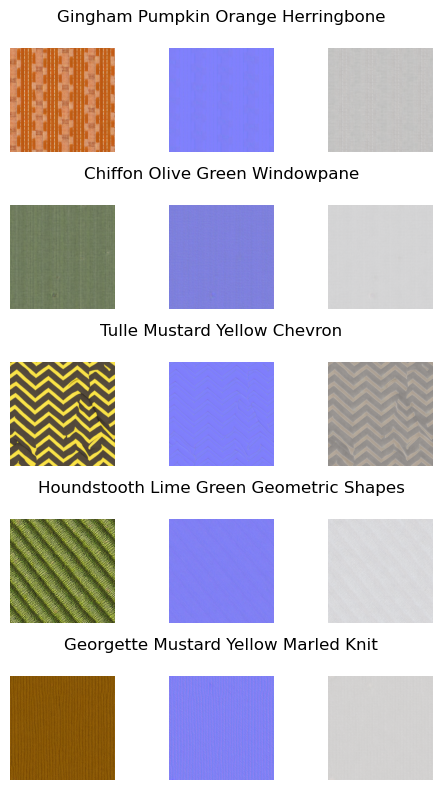

In [3]:
data_path = f"{scratch_path}/pbr_maps/dresscode"

folders = os.listdir(data_path)
print(f"In total, there are {len(folders)} texture samples in the synthetic dataset.")

subset = random.choices(folders, k=5)
fig, axs = plt.subplots(5, 3, figsize=(5, 8))
for ax_row, folder in zip(axs, subset):

    for ax, texture_type in zip(ax_row, ["diffuse", "normal", "roughness"]):
        texture_path = os.path.join(data_path, folder, f"texture_{texture_type}.png")
        img = plt.imread(os.path.join(texture_path))
        ax.imshow(img)
        ax.axis("off")
        if texture_type == "normal":
            prompt = " ".join(folder.split("_"))
            ax.set_title(f"{prompt}\n")

plt.tight_layout()

### Applying mask

In [14]:
from helpers.data_utils import generate_random_polygon, generate_polygon_mask, apply_random_mask, generate_random_square_mask
import numpy as np
from PIL import Image
import cv2

In [5]:
def generate_mask(shape, num_vertices, num_squares, min_square_size, max_square_size, mask_ratio):
    # Generate random mask
    polygon = generate_random_polygon(shape, num_vertices)  # Generate a random polygon
    base_mask = generate_polygon_mask(shape, polygon)  # Create a polygon mask
    random_mask = apply_random_mask(base_mask, mask_ratio)  # Generate a random mask
    mask = generate_random_square_mask(random_mask, num_squares, min_square_size, max_square_size)  # Add square masks
    return mask

def process_image(image, res):
    image = image.resize((res, res), Image.Resampling.NEAREST)
    image = np.array(image).astype(np.float32) / 255  # [0, 1]
    image = 2 * image - 1  # [-1, 1]
    return image

#### Synthetic masks

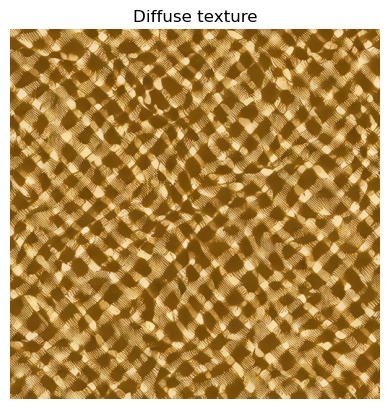

In [6]:
data_path = f"{scratch_path}/pbr_maps/dresscode"
texture_folders = os.listdir(data_path)
sample = random.choice(texture_folders)
diffuse_path = os.path.join(data_path, sample, "texture_diffuse.png")

diffuse_img = plt.imread(diffuse_path)
plt.imshow(diffuse_img)
plt.axis("off")
plt.title("Diffuse texture");

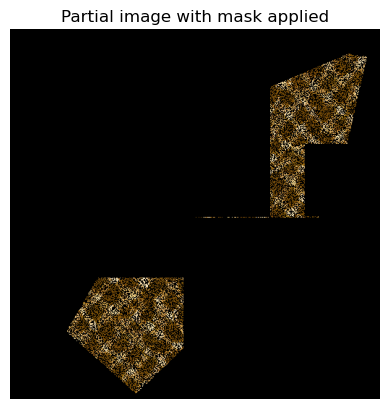

In [7]:
num_vertices, num_squares, min_square_size, max_square_size, mask_ratio, res = 8, 5, 100, 200, 0.5, 512
mask = generate_mask(diffuse_img.shape[:2], num_vertices, num_squares, min_square_size, max_square_size, mask_ratio)
diffuse_array = np.array(diffuse_img).astype(float)
partial_img_array = diffuse_array * mask[..., None]
partial_img = process_image(Image.fromarray(partial_img_array.astype(np.uint8)), res)

mask = np.array(Image.fromarray(mask).resize((res, res), Image.Resampling.NEAREST)).astype(bool)
mask = 2 * mask - 1  # [-1, 1]

plt.imshow(partial_img_array)
plt.axis("off")
plt.title("Partial image with mask applied");

#### Real masks

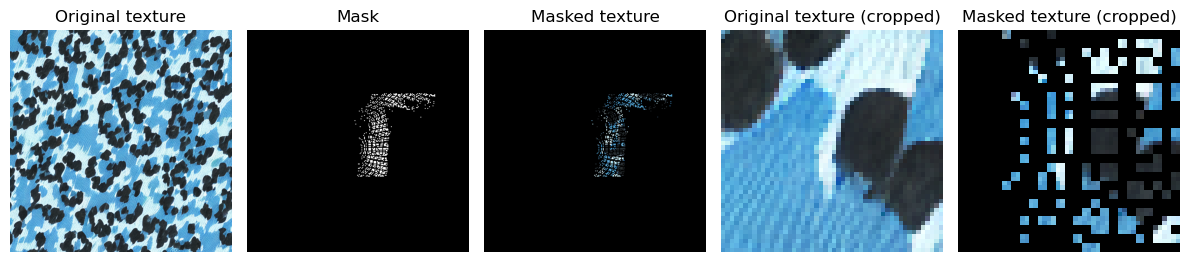

In [120]:
data_path = f"{scratch_path}/pbr_maps/dresscode"
texture_folders = os.listdir(data_path)
sample = random.choice(texture_folders)
diffuse_path = os.path.join(data_path, sample, "texture_diffuse.png")
diffuse_img = np.array(Image.open(diffuse_path)).astype(np.float32)

mask_folder = f"{scratch_path}/masks"
mask_path = os.path.join(mask_folder, "shirt.png")
mask = np.array(Image.open(mask_path).convert("L"))
mask = cv2.resize(mask, (512, 512), interpolation=cv2.INTER_NEAREST).astype("float32") / 255.0
mask = np.stack([mask] * 3, axis=-1)  # Convert to 3 channels


fig, axs = plt.subplots(1, 5, figsize=(12, 4))
axs[0].imshow(diffuse_img.astype(np.uint8))
axs[0].axis("off")
axs[0].set_title("Original texture")

axs[1].imshow(mask, cmap="gray")
axs[1].axis("off")
axs[1].set_title("Mask")

partial_img = (diffuse_img * mask).astype(np.uint8)
axs[2].imshow(partial_img)
axs[2].axis("off")
axs[2].set_title("Masked texture")

axs[3].imshow(diffuse_img[250:300, 250:300].astype(np.uint8));
axs[3].axis("off")
axs[3].set_title("Original texture (cropped)")

axs[4].imshow(partial_img[250:300, 250:300]);
axs[4].axis("off")
axs[4].set_title("Masked texture (cropped)")

plt.tight_layout()

In [112]:
diffuse_img[:10].astype(np.float32) / 255.0

array([[[0.09803922, 0.09019608, 0.09019608],
        [0.09411765, 0.09411765, 0.09019608],
        [0.09411765, 0.09411765, 0.09019608],
        ...,
        [0.09803922, 0.09019608, 0.09019608],
        [0.09803922, 0.09019608, 0.09019608],
        [0.09411765, 0.09019608, 0.09019608]],

       [[0.09803922, 0.09411765, 0.08627451],
        [0.09803922, 0.09019608, 0.08627451],
        [0.09803922, 0.09019608, 0.09019608],
        ...,
        [0.09803922, 0.09019608, 0.09019608],
        [0.09803922, 0.09019608, 0.08627451],
        [0.09803922, 0.09019608, 0.08627451]],

       [[0.09411765, 0.09019608, 0.09019608],
        [0.09411765, 0.09411765, 0.08627451],
        [0.09411765, 0.08627451, 0.08627451],
        ...,
        [0.09803922, 0.09019608, 0.08627451],
        [0.09803922, 0.09019608, 0.09019608],
        [0.09803922, 0.09019608, 0.08627451]],

       ...,

       [[0.09803922, 0.07058824, 0.07843138],
        [0.11372549, 0.11372549, 0.10980392],
        [0.84705883, 0

In [116]:
(diffuse_img*mask).min(), (diffuse_img*mask).max()

(0.0, 255.0)

## Yingxuan data format

color (512, 512, 4)
normal (512, 512, 3)
roughness (512, 512, 3)
mask (256, 256, 3)
partial_color (512, 512, 4)
mask_shirt (256, 256, 3)
partial_color_shirt (512, 512, 4)


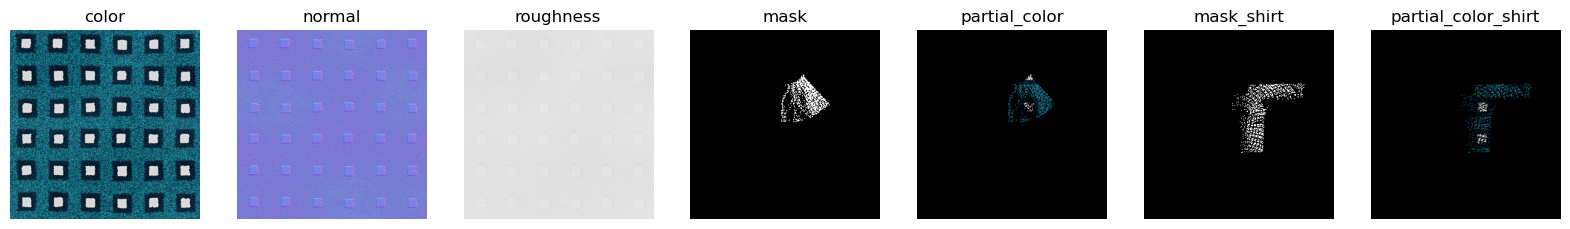

In [17]:
data_path = f"{scratch_path}/yingxuan_data/train/ambientCG/0024"

file_names = ["color", "normal", "roughness", "mask", "partial_color", "mask_shirt", "partial_color_shirt"]

fig, axs = plt.subplots(1, 7, figsize=(20, 5))

for i, file_name in enumerate(file_names): 

    img_path = os.path.join(data_path, f"{file_name}.png")
    img = plt.imread(img_path)

    print(file_name, img.shape)
    axs[i].imshow(img)
    axs[i].axis("off")

    axs[i].set_title(file_name);